In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        f.read(16)  
        images = np.fromfile(f, dtype=np.uint8)
        images = images / 255.0
        images = images.reshape(-1, 28, 28)
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        f.read(8)
        labels = np.fromfile(f, dtype=np.uint8)
    return labels



Размеры. Тренировочная выборка:  (60000, 28, 28) , метки:  (60000,)
Размеры. Тестовая выборка:  (10000, 28, 28) , метки:  (10000,)


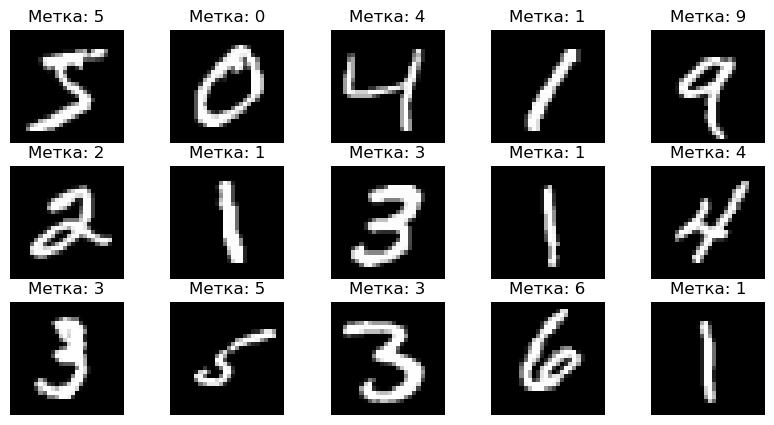

In [3]:
train_images = load_mnist_images('data/train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = load_mnist_labels('data/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = load_mnist_images('data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
print("Размеры. Тренировочная выборка: ", train_images.shape, ", метки: ", train_labels.shape)
print("Размеры. Тестовая выборка: ", test_images.shape, ", метки: ", test_labels.shape)

plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i + 1)  
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Метка: {train_labels[i]}')  
    plt.axis('off')

plt.show()

In [4]:
def ReLU(x):
    return np.maximum(0, x)

def diff_ReLU(x):
    return np.array(x>=0, dtype=np.int8)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
    return e_x / np.sum(e_x, axis = 1, keepdims = True)

#def cross_entropy(y_pred, y_true):
#    batch_size = y_pred.shape[0]
#    res = np.log(1 - y_pred)
#    res[range(batch_size), y_true.flatten()] = np.log(y_pred)[range(batch_size), y_true.flatten()]
#    return -np.sum(res) / batch_size
def cross_entropy(y_pred, y_true):
    epsilon = 1e-15  
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    batch_size = y_pred.shape[0]
    res = np.log(1 - y_pred)
    res[range(batch_size), y_true.flatten()] = np.log(y_pred)[range(batch_size), y_true.flatten()]
    return -np.sum(res) / batch_size




def accuracy(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y_pred == y_true)

In [5]:
input_size = 28 * 28  
hidden_size = 300  
output_size = 10  
learning_rate = 0.1
epochs = 20
batch_size = 32

class NN:
    def __init__(self, hidden_size):
        self.hidden_neurons_count = hidden_size
        self.input_neurons_count = input_size
        self.output_neurons_count = output_size
        
        self.W = np.random.randn(self.input_neurons_count, self.hidden_neurons_count) * np.sqrt(2.0/self.input_neurons_count)
        self.w = np.zeros((1, self.hidden_neurons_count))
        
        self.V = np.random.randn(self.hidden_neurons_count, self.output_neurons_count) * np.sqrt(2.0/self.hidden_neurons_count)
        self.v = np.zeros((1, self.output_neurons_count))
    
    def fit(self, x, y, lr):
        self.forward(x)
        self.backward(x, y)
        self.step(lr)
        return self.g
    
    def predict(self, x):
        self.forward(x)
        return self.g
    
    def forward(self, x):
        self.s = x @ self.W + self.w
        self.z = ReLU(self.s)
        self.delta_relu = diff_ReLU(self.s)
        
        self.t = self.z @ self.V + self.v
        self.g = softmax(self.t)
        
    def backward(self, x, y):
        batch_size = x.shape[0]
        
        self.delta_t = np.copy(self.g)
        self.delta_t[range(batch_size), y.flatten()] -= 1
        
        self.dV = self.z.T @ self.delta_t
        self.dv = np.sum(self.delta_t, axis=0, keepdims=True)
        
        self.delta_z = self.delta_t @ self.V.T
        self.delta_s = self.delta_z * self.delta_relu
        
        self.dW = x.T @ self.delta_s 
        self.dw = np.sum(self.delta_s, axis=0, keepdims=True)

    
    def step(self, lr):
        batch_size = self.g.shape[1]
        theta = lr / batch_size
        
        self.W -= theta * self.dW
        self.w -= theta * self.dw
        self.V -= theta * self.dV
        self.v -= theta * self.dv

In [6]:
model = NN(hidden_size)
def train(model, x_train, y_train, epochs, batch_size, learning_rate):
    for epoch in range(epochs):
        # shuffle
        # print(epoch)
        idx = np.random.permutation(len(y_train))
        x_train_perm = x_train[idx]
        y_train_perm = y_train[idx]
        
        batch_loss = []
        batch_accuracy = []
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_perm[i:i + batch_size]
            x_batch = x_batch.reshape(-1, 28 * 28)
            
            y_batch = y_train_perm[i:i + batch_size]
            y_batch = y_batch.reshape(batch_size, -1)

            output = model.fit(x_batch, y_batch, learning_rate)
            batch_loss.append(cross_entropy(output, y_batch.flatten()))
            batch_accuracy.append(accuracy(output, y_batch.flatten()))
            
        predictions = model.predict(x_train.reshape(-1, 28 * 28))
        loss = cross_entropy(predictions, y_train.flatten())
        acc = accuracy(predictions, y_train.flatten())

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}, Accuracy: {acc}')
        
train(model, train_images, train_labels, epochs, batch_size, learning_rate)

Epoch 1/20, Loss: 0.19400025664432083, Accuracy: 0.96765
Epoch 2/20, Loss: 0.12832600082555817, Accuracy: 0.9775
Epoch 3/20, Loss: 0.0788155736287085, Accuracy: 0.98615
Epoch 4/20, Loss: 0.06968044922989443, Accuracy: 0.9883666666666666
Epoch 5/20, Loss: 0.04169368603493923, Accuracy: 0.99335
Epoch 6/20, Loss: 0.04971817613732764, Accuracy: 0.9919166666666667
Epoch 7/20, Loss: 0.01854800166955873, Accuracy: 0.9978833333333333
Epoch 8/20, Loss: 0.012501623568305628, Accuracy: 0.9988666666666667
Epoch 9/20, Loss: 0.013834984878345417, Accuracy: 0.9982333333333333
Epoch 10/20, Loss: 0.005642429817257793, Accuracy: 0.99985
Epoch 11/20, Loss: 0.0034098713215707462, Accuracy: 0.9999666666666667
Epoch 12/20, Loss: 0.0027894594593641025, Accuracy: 0.9999833333333333
Epoch 13/20, Loss: 0.0021867075962268188, Accuracy: 1.0
Epoch 14/20, Loss: 0.002045055664339811, Accuracy: 0.9999666666666667
Epoch 15/20, Loss: 0.0017663405122038621, Accuracy: 1.0
Epoch 16/20, Loss: 0.001525029943965101, Accuracy

In [7]:
def test(model, x_test, y_test):
    x_test = x_test.reshape(-1, 28 * 28)
    predictions = model.predict(x_test)
    loss = cross_entropy(predictions, y_test.flatten())
    acc = accuracy(predictions, y_test.flatten())
    
    print(f'Test Loss: {loss}, Test Accuracy: {acc}')
    
test(model, test_images, test_labels)


Test Loss: 0.11697030998759406, Test Accuracy: 0.9838
